In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm

In [2]:
def convert_removing_to_inital(network_connection_removing):
    n,m = network_connection_removing.shape
    print(n,m)
    index_matrix = np.zeros((n,m))
    for i in range(n):
        row = network_connection_removing[i,:]
        row_ind = row[np.where(row)]
        index_matrix[i,:len(row_ind)] = row_ind
#         print(index_matrix[i,:])
    del_col = []
    for j in range(m):
        col = index_matrix[:,j]
        if not np.any(col):
#             print(j)
            del_col.append(j)
    return np.delete(index_matrix,del_col,1)

In [3]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
#     np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds = 10):
#     np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
#                 p_value = np.random.random()*p_max # [0, 1] * pmax
#                 p_value = 1e-1
#                 p[i][int(degree_clone[i]-degree[i])] = p_value
#                 p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix

# # @jit(nopython = True)
# def sigma_check(p,degree):
#     sigma = np.zeros(p.shape[0])
#     for i in range(p.shape[0]):
#         sigma[i] = degree[i]*p[i].sum()
#     return sigma

In [4]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0

###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [5]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [14]:
print(1e-1)

0.1


In [6]:
N = 10**5
K = 14
k_min = 2
k_max = N - 1
# sigma = 1
degree = Degree_generate_homo(N, K, k_min, k_max)
# print(np.max(degree))
# print(np.random.randint(degree.size))
# plt.plot(degree)
degree_clone = degree.copy()
network_connection = network_generate(K, degree_clone)

## propagation matrix 
network_p = np.copy(network_connection)
network_p[np.where(network_p != 0.0)] = 1e-1

## degree 
network_index = np.copy(network_connection)
network_index[np.where(network_index)] = 1
network_degree = np.sum(network_index,axis = 1)

1402271.0


Text(0.5, 1.0, 'N vs degree')

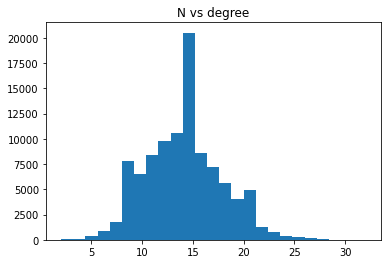

In [9]:
print(degree.sum())
plt.hist(degree,25)
plt.title('N vs degree')


In [64]:
print(degree)
print(new_degree)
print(np.where(degree!=new_degree))

print(degree[9224])
print(new_degree.sum()/N)

[13. 11. 10. ... 10.  9.  8.]
[13. 11. 10. ... 10.  9.  8.]
(array([ 9224,  9289,  9372, 10201, 16241, 17904, 37597, 43002, 50496,
       55552, 83209, 93553, 94735, 99727]),)
8.0
9.99811


In [10]:
network_index = np.copy(network_connection)
network_index[np.where(network_index)] = 1

print(network_index.sum())

network_index2 = np.copy(network_p)
network_index2[np.where(network_index2)] = 1

print(network_index2.sum())

1402255.0
1402255.0


[1.3 1.7 1.  ... 1.2 2.2 1.7]
1.402255


Text(2.0, 17500, '$<\\sigma_i>$ = 1.402255')

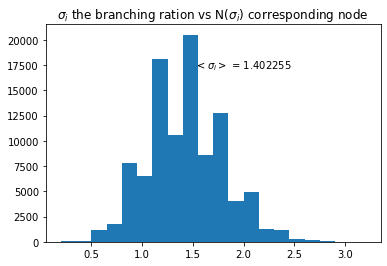

In [11]:
# p_clone = np.copy(p)
# sigma = sigma_check(p_clone,degree)
sigma_i = network_degree*0.1
print(sigma_i)
print(sigma_i.sum()/N)
plt.hist(sigma_i,20)
plt.title('$\sigma_i$ the branching ration vs N($\sigma_i$) corresponding node')
plt.text(2.0, 17500, f'$<\sigma_i>$ = {sigma_i.sum()/N}', horizontalalignment='center',
     verticalalignment='center')

In [13]:
import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [14]:
N = 10**5
K = 14
k_min = 2
k_max = N - 1
# sigma = 1
degree = Degree_generate_homo(N, K, k_min, k_max)
# print(np.max(degree))
# print(np.random.randint(degree.size))
# plt.plot(degree)
degree_clone = degree.copy()
network_connection = network_generate(K, degree_clone)

## propagation matrix 
network_p = np.copy(network_connection)
network_p[np.where(network_p != 0.0)] = 1e-1

## degree 
network_index = np.copy(network_connection)
network_index[np.where(network_index)] = 1
network_degree = np.sum(network_index,axis = 1)

In [16]:
traget_sigma = np.arange(0.6,1.4,0.01)
print(traget_sigma)

network_connection_clone = np.copy(network_connection)
network_degree_clone = np.copy(network_degree)
# print(degree_clone)
network_p_clone = np.copy(network_p)

times = 5050
r = 1/N
n = 10
t_test = np.arange(times)
p = 0.1

rho = []
sigmas = []
taus = []
F0 = []

rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
rho.append(rho_test)
tau = decay(rho_test,25)
taus.append(tau[1])
sigmas.append(round(network_degree_clone.sum()/N*p,2))
F0.append(F0_determine(rho_test))

j = 0
while j<len(traget_sigma):
    network_connection12, network_p2, network_degree2 = \
        progressive_remove_connections(network_connection_clone, network_p_clone, network_degree_clone,0.01)
    
    
    network_connection2 = convert_removing_to_inital(network_connection12)
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1)    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p
    
    network_connection_clone = np.copy(network_connection2)
    network_degree_clone = np.copy(network_degree2)
    network_p_clone = np.copy(network_p2)

    rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
    rho.append(rho_test)
    tau = decay(rho_test,25)
    taus.append(tau[1])
    sigmas.append(round(network_degree_clone.sum()/N*p,2))
    print(round(network_degree_clone.sum()/N*p,2))
    F0.append(F0_determine(rho_test))
    
    j = j +1

[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01
 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15
 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29
 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39]
100000 32
1.39
100000 32
1.38
100000 32
1.37
100000 32
1.36
100000 32
1.35
100000 32
1.34
100000 32
1.33
100000 32
1.32
100000 32
1.31
100000 32
1.3
100000 31
1.29
100000 31
1.28
100000 31
1.27
100000 30
1.26
100000 30
1.25
100000 30
1.24
100000 30
1.23
100000 30
1.22
100000 30
1.21
100000 29
1.2
100000 29
1.19
100000 29
1.18
100000 29
1.17
100000 29
1.16
100000 29
1.15
100000 29
1.14
100000 29
1.13
100000 29
1.12
100000 29
1.11
100000 29
1.1
100000 29
1.09
100000 29
1.08
100000 29
1.07
100000 29
1.06
100000 29
1.05
100000 29
1.04
100000 29
1.03
100000 29
1.02
100000 29
1.01
100000 26
1

In [31]:
import scipy.io as scio
scio.savemat(f'Aging_network/Timeseries_{K}.mat',{'sigmas':sigmas,'rho':rho,'intf':taus,'F0':F0})

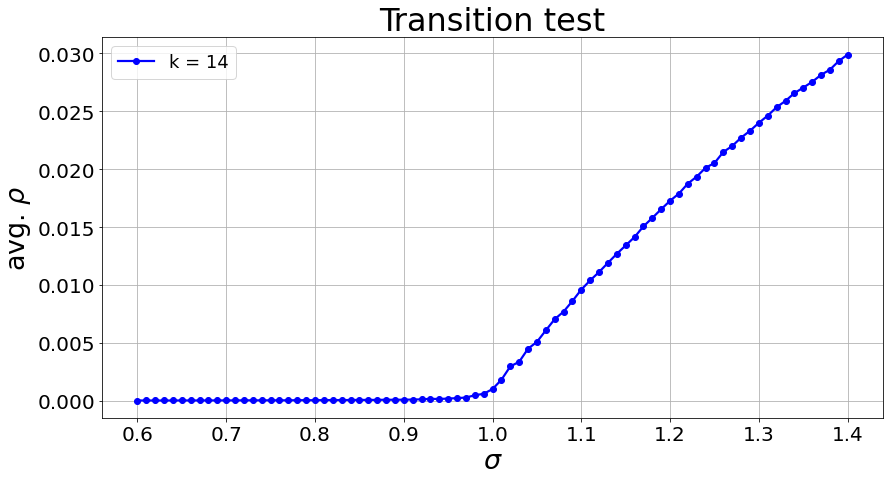

In [29]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(sigmas, F0, color = 'blue', linewidth=2.2, linestyle='-', marker = 'o', label = 'k = %d'%(K))

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('avg. $\\rho$ ',fontsize=27)
ax.set_title('Transition test',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

In [25]:
sigmas = np.array(sigmas)
sigmas
taus= np.array(taus)

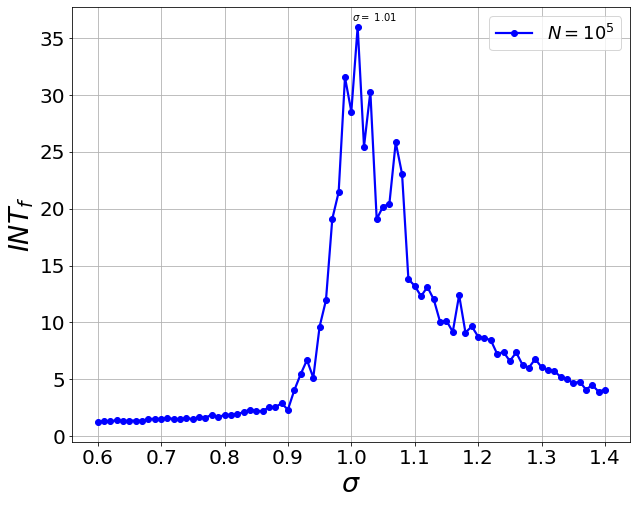

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(sigmas,taus, color='blue', linewidth=2.2, linestyle='-', marker = 'o',  label = '$N = 10^{%d}$'%(5))

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('$INT_f$ ',fontsize=27)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
ax.annotate(f'$\sigma = $ {sigmas[np.argmax(taus)]}',
                        xy=(sigmas[np.argmax(taus)], taus.max()),
                        xytext=(-6,6),  # 4 points vertical offset.
                        textcoords='offset points')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

In [19]:
print(sigmas)
# np.where(sigmas == 0.8)

[1.4, 1.39, 1.38, 1.37, 1.36, 1.35, 1.34, 1.33, 1.32, 1.31, 1.3, 1.29, 1.28, 1.27, 1.26, 1.25, 1.24, 1.23, 1.22, 1.21, 1.2, 1.19, 1.18, 1.17, 1.16, 1.15, 1.14, 1.13, 1.12, 1.11, 1.1, 1.09, 1.08, 1.07, 1.06, 1.05, 1.04, 1.03, 1.02, 1.01, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8, 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6]


[60]
[40]
[20]
[0]


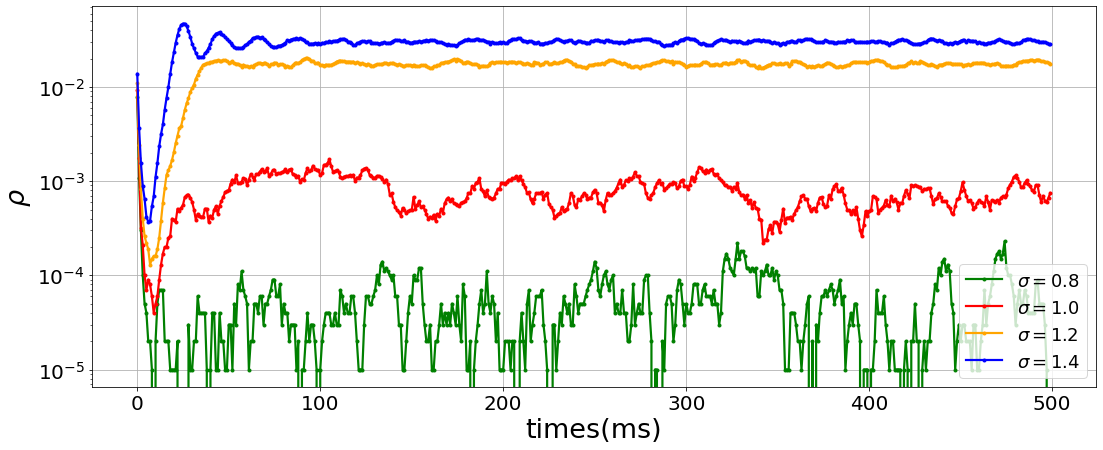

In [27]:
sigmas = np.array(sigmas)
# sigmas = np.array(sigmas)
targets = [0.8,1.0,1.2,1.4]
fig, ax = plt.subplots(figsize=(18, 7))
color = ['green', 'red', 'orange', 'blue']
for n, i in enumerate(targets):
    ind = np.where(sigmas == i)[0]
    print(ind)   
    rho_t = rho[int(ind)]
    ax.plot(t_test[:500], rho_t[:500], marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
            label = '$\sigma=%.1f$'%(i))

ax.set_xlabel('times(ms)',fontsize=27)
ax.set_ylabel('$\\rho$',fontsize=27)
# ax.set_title('Activity test',fontsize=32)
ax.set_yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()
# print('Time cost:', time.time()-start_i)

In [7]:
# @jit(nopython = True)
def remove_node_connections_todegree(network_connection, K, avgd = 9 ):
    network_connection_clone = np.copy(network_connection)
    new_mean_degree = K
    
    while new_mean_degree > avgd:
        network_connection = remove_node_connections(network_connection_clone)
        new_degree = new_network_degree(network_connection)
        new_mean_degree = new_degree.mean()
    print(new_mean_degree)
    return  network_connection

@jit(nopython = True)
def remove_ini_node_and_connections(network_connection,p, ratio = 0.001, seeds = 10): # ratio should less than 0.005
    
    np.random.seed(seeds)
    N = network_connection.shape[0]
    num_of_removed_node = int(ratio*N)
#     print(num_of_removed_node)
    remove_list = np.random.choice(N, size = num_of_removed_node, replace = False)
    new_network_connection = np.delete(network_connection,remove_list,axis = 0) # removing the node
    new_p = np.delete(p,remove_list,axis = 0)
    
#     flag = 0;
    for i in remove_list: # removing the node connections
        node_connections_removing = np.where(new_network_connection == i)
        if node_connections_removing[0].size!=0:
            for i,j in list(zip(node_connections_removing[0], node_connections_removing [1])):
#                 flag = flag+1
                new_network_connection[i,j] = 0
                new_p[i,j] = 0
#     print(flag)
    return new_network_connection,new_p

# @jit(nopython = True)
def remove_connections_to_sigma(network_connection, network_p, degree, sigma, p_value = 0.1,  seeds = 10):
    # p_value, the propagation rate 
    # the wanted sigma
    np.random.seed(seeds)
    ini_sigma = round(np.sum(degree)/N)*p_value
    if sigma>ini_sigma:
        raise NameError('the traget sigma should less than initial sigma')
        
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    xys = np.where(network_index)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections = int((ini_sigma-sigma)/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_index[x,y] = 0
        network_connection[x,y] = 0
        network_p[x,y] = 0
    new_degree = np.sum(network_index,axis = 1)
    return network_connection,network_p,new_degree


def progressive_remove_connections(network_connection, network_p, degree, sigma_difference, p_value = 0.1):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    xys = np.where(network_index)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections = int(sigma_difference/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_index[x,y] = 0
        network_connection[x,y] = 0
        network_p[x,y] = 0
    new_degree = np.sum(network_index,axis = 1)
    return network_connection,network_p,new_degree

In [68]:
network_connection2, network_p2 = remove_ini_node_and_connections(network_connection,network_p)
network_index = np.copy(network_connection2)
network_index[np.where(network_index)] = 1
network_degree2 = np.sum(network_index,axis = 1)

In [94]:
network_index = np.copy(network_connection2)
network_index[np.where(network_index)] = 1
network_degree2 = np.sum(network_index,axis = 1)
print((round(np.sum(network_degree2)/N)*0.1))
# print(np.sum(new_degree)/N*p,2)

network_connection3,network_p3, network_degree3 = \
    remove_connections_to_sigma(network_connection2,network_p2, network_degree2, 0.99)

1.0


0.99


Text(0.5, 1.0, 'N vs degree')

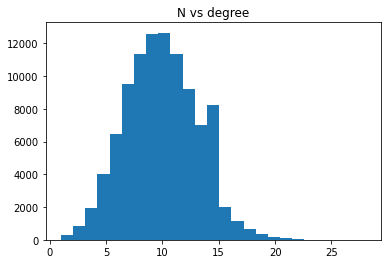

In [102]:
# plt.hist(network_degree3)
print(round(network_degree3.sum()/N*0.1,2))
plt.hist(network_degree3,25)
plt.title('N vs degree')

In [17]:
import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [ ]:
iteration  = 100;
ratios = [0.01,0.02,0.03,0.04,0.05]

times = 100
r = 0.00001
n = 10
t_test = np.arange(times)
p = 0.1

rho = []
sigmas = []
taus = []
for ratio in ratios:
    for _ in range(iteration) :
        network_connection_dis = remove_node_connections(network_connection, ratio)
        remove_node_degree = new_network_degree(network_connection_dis)
        sigma = round(remove_node_degree.mean()*p,2)
        if sigma not in sigmas:
            sigmas.append(sigma)    
            network_p = np.copy(network_connection)
            network_p[np.where(network_p != 0.0)] = 10e-2
                       
            rho_test = KC_model(remove_node_degree, network_connection_dis, network_p, 0, times, r, times, n)
            rho.append(rho_test)
            tau = decay(rho_test,25)
            taus.append(tau[1])

In [70]:
# print(rho) 
print(sigmas) 
print(taus)

[0.95]
[0.7402199781922387]


(95000, 28)


Text(0, 8000, 'mean degree: 9.5')

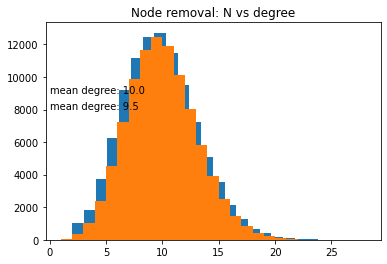

In [71]:
# print(rho) 
# print(sigmas) 
# print(taus)

plt.hist(degree,25)
plt.title('Node removal: N vs degree')
plt.text(0,9000,f'mean degree: {round(degree.mean(),1)}')

network_connection_dis = remove_node_connections(network_connection, 0.05)

print(network_connection_dis.shape)
remove_node_degree = new_network_degree(network_connection_dis)
plt.hist(remove_node_degree,25)
plt.title('Node removal: N vs degree')
plt.text(0,8000,f'mean degree: {round(remove_node_degree.mean(),1)}')

In [41]:
N = network_connection.shape[0]
print(network_connection.shape)
num_of_removed_node = int(0.05*N)
print(num_of_removed_node)
np.random.seed(10)
remove_list = np.random.choice(N, size=num_of_removed_node,replace = False)
print(remove_list.shape)

new_network_connection= np.delete(network_connection,remove_list,axis = 0)
flag = 0
for i in remove_list:
    node_connections_removing = np.where(new_network_connection == i)
    if node_connections_removing[0].size!=0:
        for i,j in list(zip(node_connections_removing[0], node_connections_removing [1])):
            flag = flag+1
            new_network_connection[i,j] = 0
print(flag)
print(np.sum(new_network_connection == 0))

# print(np.sum(remove_node_connections(network_connection) == -1))

(100000, 28)
5000
(5000,)
47572
1757727


(97000, 28)


Text(0, 8000, 'mean degree: 18.3')

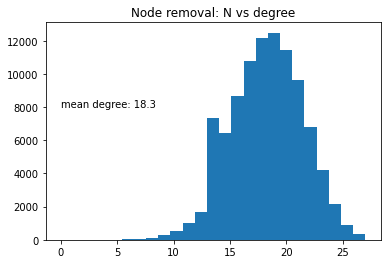

In [55]:
print(network_connection_dis.shape)
remove_node_degree = new_network_degree(network_connection_dis)
plt.hist(remove_node_degree,25)
plt.title('Node removal: N vs degree')
plt.text(0,8000,f'mean degree: {round(remove_node_degree.mean(),1)}')

In [49]:
sigma2 = remove_node_degree.mean()*0.1
print(round(sigma2,2))

1.85


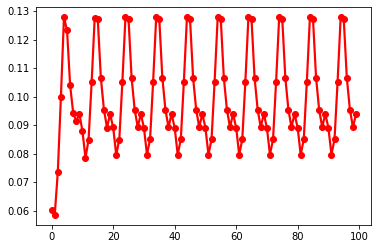

In [44]:
network_p = np.copy(new_network_connection)
network_p[np.where(network_p != 0.0)] = 10e-1
times = 100
r = 0.00001
n = 10
t_test = np.arange(times)
rho_test = KC_model(remove_node_degree, new_network_connection, network_p, 0, times, r, times, n)
plt.plot(t_test, rho_test, marker = 'o', color = 'red', linewidth=2.2, linestyle='-')

In [ ]:
rho_test

In [63]:
a = np.random.randint(10,size = (20,5))
print(a)
print(new_network_degree(a))

b = [0,1,2,3,4]
ind2 = [np.where(a == i) for i in b  ]
print(ind2)


for bi in b:
    m = np.where(a == bi)
    if m[0].size!=0:
        for i,j in list(zip(m[0],m[1])):
            a[i,j] = 0
print(a)
print(new_network_degree(a))
# ind2 = [np.where(a == i)  ]
# print(ind2)
# for x,y in ind2:
#     print(x,y)
#     print(list(zip(x,y)))
    
#     for i,j in list(zip(x,y)):
#         a[i,j] = 100
# #     break
# print(a)
# a[ind2] == 0


# print(x.size)
# if x[0]&y[0]:
#     print(x[0],y[0])
# print()

# print(a)

[[2 2 7 1 0]
 [5 7 1 1 1]
 [8 9 9 8 9]
 [2 9 4 7 8]
 [8 4 2 1 1]
 [7 5 7 9 6]
 [8 4 2 4 1]
 [1 9 2 0 5]
 [7 1 1 5 8]
 [5 5 5 9 3]
 [1 1 3 9 2]
 [6 9 9 6 1]
 [9 9 4 6 5]
 [0 1 8 1 8]
 [1 3 8 6 2]
 [5 1 0 5 1]
 [9 7 4 5 6]
 [7 4 4 7 0]
 [1 8 4 5 5]
 [0 9 1 8 2]]
[4 5 5 5 5 5 5 4 5 5 5 5 5 4 5 4 5 4 5 4]
[(array([ 0,  7, 13, 15, 17, 19]), array([4, 3, 0, 2, 4, 0])), (array([ 0,  1,  1,  1,  4,  4,  6,  7,  8,  8, 10, 10, 11, 13, 13, 14, 15,
       15, 18, 19]), array([3, 2, 3, 4, 3, 4, 4, 0, 1, 2, 0, 1, 4, 1, 3, 0, 1, 4, 0, 2])), (array([ 0,  0,  3,  4,  6,  7, 10, 14, 19]), array([0, 1, 0, 2, 2, 2, 4, 4, 4])), (array([ 9, 10, 14]), array([4, 2, 1])), (array([ 3,  4,  6,  6, 12, 16, 17, 17, 18]), array([2, 1, 1, 3, 2, 2, 1, 2, 2]))]
[[0 0 7 0 0]
 [5 7 0 0 0]
 [8 9 9 8 9]
 [0 9 0 7 8]
 [8 0 0 0 0]
 [7 5 7 9 6]
 [8 0 0 0 0]
 [0 9 0 0 5]
 [7 0 0 5 8]
 [5 5 5 9 0]
 [0 0 0 9 0]
 [6 9 9 6 0]
 [9 9 0 6 5]
 [0 0 8 0 8]
 [0 0 8 6 0]
 [5 0 0 5 0]
 [9 7 0 5 6]
 [7 0 0 7 0]
 [0 8 0 5 5]
 [0 9 0 8 0]]

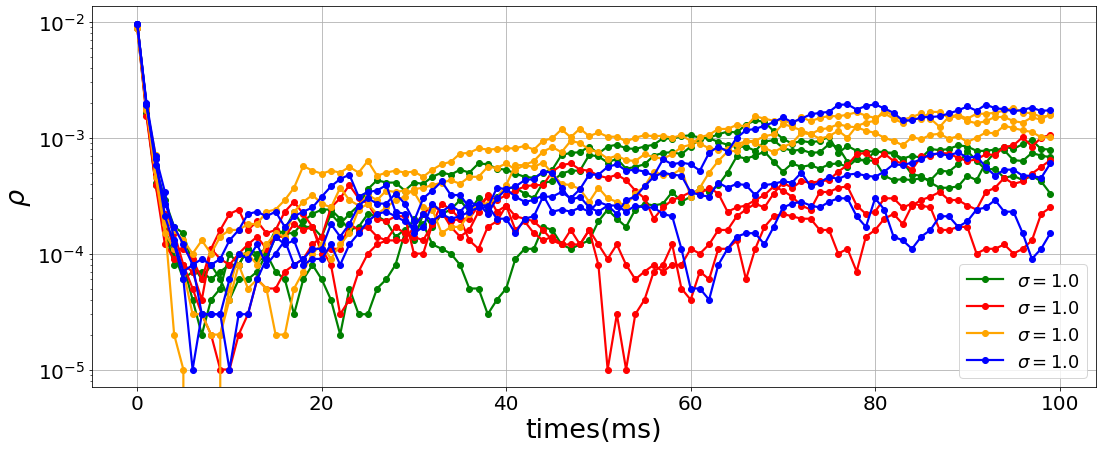

Time cost: 61.88708209991455


In [48]:
start_i = time.time()
state_num_list = [5,10]
sigma_list = [0.9, 1.0, 1.1, 2.0]
# sigma_list = [1.0, 1.5, 2.0]
color = ['green', 'red', 'orange', 'blue']
r = 0.00001
times = 100 # 100 s  100 ms
fig, ax = plt.subplots(figsize=(18, 7))
t_test = np.arange(times)
for i in range (12):
    sigma = sigma_list[i//3] # each sigma run 3 times    
    N = 10**5 
    K = 10
    k_min = 2
    k_max = N - 1
    n = state_num_list[1]
    degree = Degree_generate_homo(N, K, k_min, k_max)
    degree_clone = degree.copy()
    network_connection, p  = network_generate(K, degree_clone,10)
    
    # generate the random network,
    # p is function of sigma, pmax = 2*sigma/k, p_value = np.random.random()*p_max
    # the node sigma sigma_i = sum(pij), j is the connecting node of i
    # network_connection & p n*m n: the num of node and m: the max degree
    p_clone = np.copy(p)
    sigma_i = sigma_check(p_clone)
    sigma_mean = sigma_i.mean()
    rho_test = KC_model(degree, network_connection, p, 0, times, r, times, n)
    np.save('rho_test_'+str(i%3)+str(sigma)+'.npy',rho_test)
    if(i%3):
        ax.plot(t_test, rho_test, marker = 'o', color = color[i//3], linewidth=2.2, linestyle='-')
    else:
        ax.plot(t_test, rho_test, marker = 'o', color = color[i//3], linewidth=2.2, linestyle='-'\
                , label = '$\sigma=%.1f$'%(sigma_mean))
        
        
ax.set_xlabel('times(ms)',fontsize=27)
ax.set_ylabel('$\\rho$',fontsize=27)
# ax.set_title('Activity test',fontsize=32)
ax.set_yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()
# plt.savefig(f'Instantaneous_density_t100.png', dpi=500, bbox_inches='tight')
plt.show()
print('Time cost:', time.time()-start_i)